# Um breve tour do Fatiando a Terra

In [1]:
import fatiando

In [2]:
print(fatiando.__version__)

0.4


## Criando formas geométricas

In [3]:
from fatiando import mesher

In [4]:
prisma = mesher.Prism(1, 5, 9, 29, 0, 3)

In [5]:
prisma

In [6]:
prisma.get_bounds()

[1.0, 5.0, 9.0, 29.0, 0.0, 3.0]

In [7]:
prisma.addprop('density', 250)

In [8]:
prisma.props

{'density': 250}

In [10]:
from fatiando.vis import myv

In [21]:
modelo = [prisma]

myv.figure()
myv.prisms(modelo)
myv.show()

In [12]:
myv.figure()
myv.prisms(modelo, 'density')
bounds = [0, 20, 0, 30, 0, 20]
myv.outline(bounds)
myv.wall_north(bounds)
myv.show()

## Modelagem direta

In [13]:
from fatiando import gridder

In [14]:
x, y = gridder.regular(bounds[:4], (50, 50))

In [15]:
x, y

(array([  0.,   0.,   0., ...,  20.,  20.,  20.]),
 array([  0.       ,   0.6122449,   1.2244898, ...,  28.7755102,
         29.3877551,  30.       ]))

In [16]:
import numpy as np

In [17]:
z = np.zeros_like(x)

In [22]:
z

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [23]:
from fatiando.gravmag import prism

In [24]:
grav = prism.gz(x, y, z, modelo)

In [25]:
grav

array([  1.46259702e-04,   1.67193826e-04,   1.92472377e-04, ...,
         8.00824216e-05,   7.73293301e-05,   7.45338335e-05])

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

/home/leo/bin/anaconda/envs/fatiando-talk/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


<matplotlib.tri.tricontour.TriContourSet instance at 0x7fd258d05710>

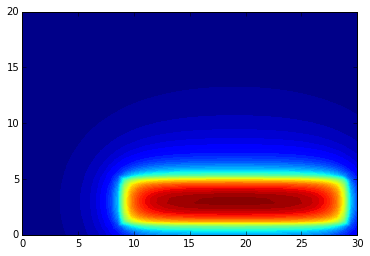

In [27]:
plt.tricontourf(y, x, grav, 60)

## Dados grav

In [28]:
lon, lat, y, x, alt, topo, grav = np.loadtxt('gravidade-havai.txt', unpack=True)

<matplotlib.tri.tricontour.TriContourSet instance at 0x7fd256071050>

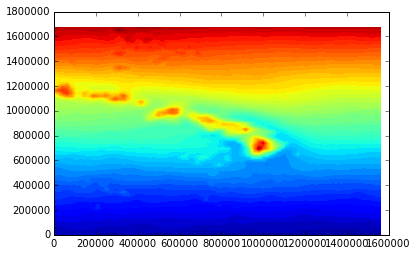

In [29]:
plt.tricontourf(y, x, grav, 60)

In [30]:
from fatiando.gravmag import normal_gravity

In [31]:
disturbio = grav - normal_gravity.gamma_closed_form(lat, alt)

<matplotlib.colorbar.Colorbar instance at 0x7fd255cbb6c8>

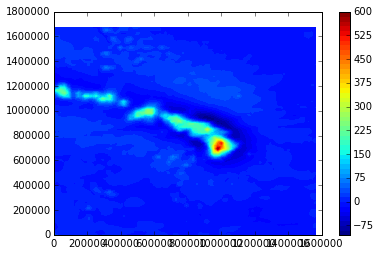

In [32]:
plt.tricontourf(y, x, disturbio, 60)
plt.colorbar()

In [33]:
bouguer = disturbio - normal_gravity.bouguer_plate(topo)

<matplotlib.colorbar.Colorbar instance at 0x7fd255a993f8>

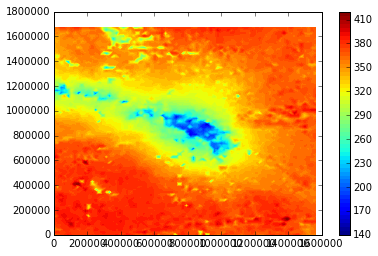

In [34]:
plt.tricontourf(y, x, bouguer, 60)
plt.colorbar()

# Anomalia magnética